In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
import copy
import json
import sys

import pandas as pd
import torch
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
import numpy as np
# NOTE changed normalization
from Problems.CNOBenchmarks_new_normalization import Darcy, Airfoil, DiscContTranslation, ContTranslation, AllenCahn, SinFrequency, WaveEquation, ShearLayer

2023-12-05 12:55:22.843436: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-05 12:55:23.605793: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-12.1/extras/CUPTI/lib64::/usr/local/cuda-12.1/targets/x86_64-linux/lib::/usr/local/cuda-12.1/lib64::/usr/local/cuda-12.1/extras/CUPTI/lib64::/usr/local/cuda-12.1/targets/x86_64-linux/lib::/usr/local/cuda-12.1/lib64:
2023-12-05 12:55:23.605889: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror

In [3]:
import numpy as np
from matplotlib import pyplot as plt
val_errors = np.load('TrainedModels/UNet_original_poisson_1/test_error.npy')

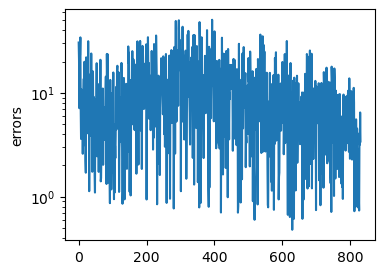

In [4]:
plt.figure(figsize=(4,3))
plt.plot(val_errors)
plt.yscale('log')
plt.ylabel('errors')
plt.show()
plt.close()

In [3]:
training_properties = {
    "learning_rate": 0.001, # CHECKED
    "scheduler_step": 10,
    "scheduler_gamma": 0.98, # CHECKED
    "epochs": 1000,
    "batch_size": 32,
    "exp": 1,                # Do we use L1 or L2 errors? Default: L1
    "training_samples": 256  # How many training samples?
}
model_architecture_ = {
    
    #Parameters to be chosen with model selection:
    # "N_layers": 3,            # Number of (D) & (U) blocks CHANGE M
    # "channel_multiplier": 32, # Parameter d_e (how the number of channels changes) CHANGE
    # "N_res": 4,               # Number of (R) blocks in the middle networs. CHANGE
    # "N_res_neck" : 6,         # Number of (R) blocks in the BN CHANGE, r
    
    #Other parameters:
    "in_size": 64,            # Resolution of the computational grid
    "retrain": 4,             # Random seed
    "kernel_size": 3,         # Kernel size. CHECKED
    "FourierF": 0,            # Number of Fourier Features in the input channels. Default is 0.
    "activation": 'cno_lrelu',# cno_lrelu or lrelu
    
    #Filter properties:
    "cutoff_den": 2.0001,     # Cutoff parameter.
    "lrelu_upsampling": 2,    # Coefficient N_{\sigma}. Default is 2.
    "half_width_mult": 0.8,   # Coefficient c_h. Default is 1 CHECKED
    "filter_size": 6,         # 2xfilter_size is the number of taps N_{tap}. Default is 6. CHECKED
    "radial_filter": 0,       # Is the filter radially symmetric? Default is 0 - NO.
}

#   "which_example" can be 

#   poisson             : Poisson equation 
#   wave_0_5            : Wave equation
#   cont_tran           : Smooth Transport
#   disc_tran           : Discontinuous Transport
#   allen               : Allen-Cahn equation
#   shear_layer         : Navier-Stokes equations
#   airfoil             : Compressible Euler equations
#   darcy               : Darcy Flow

which_example = 'poisson'


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# NOTE moved most of the hyperparameter variables to after the individual example setup
batch_size = training_properties["batch_size"]


# NOTE add ood example, set correct training sample size
if which_example == "shear_layer":
    training_properties.update({
        "weight_decay": 1e-10, # CHANGE
    })
    model_architecture_.update({
        #Parameters to be chosen with model selection:
        "N_layers": 3,            # Number of (D) & (U) blocks CHANGE M
        "channel_multiplier": 32, # Parameter d_e (how the number of channels changes) CHANGE
        "N_res": 1,               # Number of (R) blocks in the middle networs. CHANGE
        "N_res_neck" : 8,         # Number of (R) blocks in the BN CHANGE, r
    })
    training_samples = training_properties["training_samples"] = 750
    example = ShearLayer(model_architecture_, device, batch_size, training_samples, size = 64)
    ood_example = ShearLayer(model_architecture_, device, batch_size, training_samples, size = 64, in_dist=False)
elif which_example == "poisson":
    training_properties.update({
        "weight_decay": 1e-6, # CHANGE
    })
    model_architecture_.update({
        #Parameters to be chosen with model selection:
        "N_layers": 3,            # Number of (D) & (U) blocks CHANGE M
        "channel_multiplier": 16, # Parameter d_e (how the number of channels changes) CHANGE
        "N_res": 4,               # Number of (R) blocks in the middle networs. CHANGE
        "N_res_neck" : 6,         # Number of (R) blocks in the BN CHANGE, r
    })
    training_samples = training_properties["training_samples"] = 1024
    example = SinFrequency(model_architecture_, device, batch_size, training_samples)
    ood_example = SinFrequency(model_architecture_, device, batch_size, training_samples, in_dist=False)
elif which_example == "wave_0_5":
    training_properties.update({
        "weight_decay": 1e-10, # CHANGE
    })
    model_architecture_.update({
        #Parameters to be chosen with model selection:
        "N_layers": 3,            # Number of (D) & (U) blocks CHANGE M
        "channel_multiplier": 48, # Parameter d_e (how the number of channels changes) CHANGE
        "N_res": 4,               # Number of (R) blocks in the middle networs. CHANGE
        "N_res_neck" : 6,         # Number of (R) blocks in the BN CHANGE, r
    })
    training_samples = training_properties["training_samples"] = 512
    example = WaveEquation(model_architecture_, device, batch_size, training_samples)
    ood_example = WaveEquation(model_architecture_, device, batch_size, training_samples, in_dist=False)
elif which_example == "allen":
    training_properties.update({
        "weight_decay": 1e-6, # CHANGE
    })
    model_architecture_.update({
        #Parameters to be chosen with model selection:
        "N_layers": 3,            # Number of (D) & (U) blocks CHANGE M
        "channel_multiplier": 48, # Parameter d_e (how the number of channels changes) CHANGE
        "N_res": 4,               # Number of (R) blocks in the middle networs. CHANGE
        "N_res_neck" : 8,         # Number of (R) blocks in the BN CHANGE, r
    })
    training_samples = training_properties["training_samples"] = 256
    example = AllenCahn(model_architecture_, device, batch_size, training_samples)
    ood_example = AllenCahn(model_architecture_, device, batch_size, training_samples, in_dist=False)
elif which_example == "cont_tran":
    training_properties.update({
        "weight_decay": 1e-6, # CHANGE
    })
    model_architecture_.update({
        #Parameters to be chosen with model selection:
        "N_layers": 3,            # Number of (D) & (U) blocks CHANGE M
        "channel_multiplier": 32, # Parameter d_e (how the number of channels changes) CHANGE
        "N_res": 2,               # Number of (R) blocks in the middle networs. CHANGE
        "N_res_neck" : 6,         # Number of (R) blocks in the BN CHANGE, r
    })
    training_samples = training_properties["training_samples"] = 512
    example = ContTranslation(model_architecture_, device, batch_size, training_samples)
    ood_example = ContTranslation(model_architecture_, device, batch_size, training_samples, in_dist=False)
elif which_example == "disc_tran":
    training_properties.update({
        "weight_decay": 1e-6, # CHANGE
    })
    model_architecture_.update({
        #Parameters to be chosen with model selection:
        "N_layers": 3,            # Number of (D) & (U) blocks CHANGE M
        "channel_multiplier": 32, # Parameter d_e (how the number of channels changes) CHANGE
        "N_res": 5,               # Number of (R) blocks in the middle networs. CHANGE
        "N_res_neck" : 4,         # Number of (R) blocks in the BN CHANGE, r
    })
    training_samples = training_properties["training_samples"] = 512
    example = DiscContTranslation(model_architecture_, device, batch_size, training_samples)
    ood_example = DiscContTranslation(model_architecture_, device, batch_size, training_samples, in_dist=False)
elif which_example == "airfoil":
    training_properties.update({
        "weight_decay": 1e-10, # CHANGE
    })
    model_architecture_.update({
        #Parameters to be chosen with model selection:
        "N_layers": 4,            # Number of (D) & (U) blocks CHANGE M
        "channel_multiplier": 48, # Parameter d_e (how the number of channels changes) CHANGE
        "N_res": 1,               # Number of (R) blocks in the middle networs. CHANGE
        "N_res_neck" : 8,         # Number of (R) blocks in the BN CHANGE, r
    })
    training_samples = training_properties["training_samples"] = 750
    model_architecture_["in_size"] = 128
    example = Airfoil(model_architecture_, device, batch_size, training_samples)
    ood_example = Airfoil(model_architecture_, device, batch_size, training_samples, in_dist=False)
elif which_example == "darcy":
    training_properties.update({
        "weight_decay": 1e-6, # CHANGE
    })
    model_architecture_.update({
        #Parameters to be chosen with model selection:
        "N_layers": 3,            # Number of (D) & (U) blocks CHANGE M
        "channel_multiplier": 48, # Parameter d_e (how the number of channels changes) CHANGE
        "N_res": 4,               # Number of (R) blocks in the middle networs. CHANGE
        "N_res_neck" : 4,         # Number of (R) blocks in the BN CHANGE, r
    })
    training_samples = training_properties["training_samples"] = 256
    example = Darcy(model_architecture_, device, batch_size, training_samples)
    ood_example = Darcy(model_architecture_, device, batch_size, training_samples, in_dist=False)
else:
    raise ValueError()

    
#-----------------------------------Train--------------------------------------
model = example.model
n_params = model.print_size()
train_loader = example.train_loader #TRAIN LOADER
val_loader = example.val_loader #VALIDATION LOADER
# NOTE add ood loader
test_loader = example.test_loader
ood_test_loader = ood_example.test_loader


Total number of model parameters: 748841 (~2.86MiB)


In [4]:
model = torch.load('eth/eth_poisson_model.pkl', map_location=torch.device(device))

In [5]:
with torch.no_grad():
    model.eval()
    final_test_relative_l2 = []
    
    for step, (input_batch, output_batch) in enumerate(test_loader):
        
        input_batch = input_batch.to(device)
        output_batch = output_batch.to(device)
        output_pred_batch = model(input_batch)
        
        if which_example == "airfoil": #Mask the airfoil shape
            output_pred_batch[input_batch==1] = 1
            output_batch[input_batch==1] = 1
        
        loss_f = torch.mean(abs(output_pred_batch - output_batch), axis = [1,2,3]) / torch.mean(abs(output_batch), axis = [1,2,3]) * 100
        final_test_relative_l2.append(loss_f.detach().cpu().numpy())
    final_test_relative_l2 = np.concatenate(final_test_relative_l2, 0)

    ood_test_relative_l2 = []
    
    for step, (input_batch, output_batch) in enumerate(ood_test_loader):
        
        input_batch = input_batch.to(device)
        output_batch = output_batch.to(device)
        output_pred_batch = model(input_batch)
        
        if which_example == "airfoil": #Mask the airfoil shape
            output_pred_batch[input_batch==1] = 1
            output_batch[input_batch==1] = 1
        
        loss_f = torch.mean(abs(output_pred_batch - output_batch), axis = [1,2,3]) / torch.mean(abs(output_batch), axis = [1,2,3]) * 100
        ood_test_relative_l2.append(loss_f.detach().cpu().numpy())
    ood_test_relative_l2 = np.concatenate(ood_test_relative_l2, 0)

print(np.median(final_test_relative_l2).item())
print(np.median(ood_test_relative_l2).item())

Setting up PyTorch plugin "filtered_lrelu_plugin"... Done.
0.2109133005142212
0.2718319892883301


In [6]:
model = torch.load('TrainedReportedModels_NoEarlyStopping_new_normalization/CNO_poisson_1/model.pkl', map_location=torch.device(device))

In [7]:
with torch.no_grad():
    model.eval()
    final_test_relative_l2 = []
    
    for step, (input_batch, output_batch) in enumerate(test_loader):
        
        input_batch = input_batch.to(device)
        output_batch = output_batch.to(device)
        output_pred_batch = model(input_batch)
        
        if which_example == "airfoil": #Mask the airfoil shape
            output_pred_batch[input_batch==1] = 1
            output_batch[input_batch==1] = 1
        
        loss_f = torch.mean(abs(output_pred_batch - output_batch), axis = [1,2,3]) / torch.mean(abs(output_batch), axis = [1,2,3]) * 100
        final_test_relative_l2.append(loss_f.detach().cpu().numpy())
    final_test_relative_l2 = np.concatenate(final_test_relative_l2, 0)

    ood_test_relative_l2 = []
    
    for step, (input_batch, output_batch) in enumerate(ood_test_loader):
        
        input_batch = input_batch.to(device)
        output_batch = output_batch.to(device)
        output_pred_batch = model(input_batch)
        
        if which_example == "airfoil": #Mask the airfoil shape
            output_pred_batch[input_batch==1] = 1
            output_batch[input_batch==1] = 1
        
        loss_f = torch.mean(abs(output_pred_batch - output_batch), axis = [1,2,3]) / torch.mean(abs(output_batch), axis = [1,2,3]) * 100
        ood_test_relative_l2.append(loss_f.detach().cpu().numpy())
    ood_test_relative_l2 = np.concatenate(ood_test_relative_l2, 0)

print(np.median(final_test_relative_l2).item())
print(np.median(ood_test_relative_l2).item())

0.2851915657520294
0.43258821964263916
